<h1><center><font size="6">Credit Card Fraud Detection Predictive Models</font></center></h1>


# <a>Introduction</a>

Credit card fraud poses a persistent threat to financial institutions and consumers, necessitating advanced detection mechanisms to safeguard transactions and uphold confidence in digital payments. Identifying fraudulent activities swiftly is paramount to reducing economic losses and ensuring customer satisfaction.

This report examines a dataset of credit card transactions from European cardholders, spanning two days in September 2013. Sourced from Kaggle, the dataset comprises **284,807** transactions, with only **492 (0.172%)** classified as fraudulent, highlighting a pronounced class imbalance that challenges conventional classification approaches.

Features **V1** through **V28** are principal components derived from a PCA transformation to protect sensitive information. The dataset includes two non-transformed features: Time, representing seconds elapsed since the first transaction, and Amount, indicating the transaction value. The target variable, Class, is binary, with one denoting fraud and 0 indicating legitimate transactions.


# <a>Install required Packages</a>

In [ ]:
# # We are letting catboost the necessary version of Numpy for removing any incompactability
# !pip install catboost

# # Remove and install necessary numpy for CatBooster
# !pip uninstall numpy -y
# !pip install numpy==1.24.3
# #
# # Restart Session after this
!pip install imbalanced-learn xgboost scikit-learn


# <a>Load packages</a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', 100)

from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold


RFC_METRIC = 'gini'  # RandomForrestClassifier
NUM_ESTIMATORS = 100 # Estimators RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
VALID_SIZE = 0.20
TEST_SIZE = 0.20

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation


RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

# <a id="3">Read the data</a>

In [ ]:
# If stored in Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_df = pd.read_csv("/content/drive/MyDrive/Predictive_dataset/creditcard.csv")

# <a id="4">Check the data</a>

In [ ]:
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Credit Card Fraud Detection data -  rows: 284807  columns: 31


## <a>Glimpse the data</a>

In [ ]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The data contains **284,807** transactions, during 2 consecutive days (or **172792** seconds).

## <a>Check missing data</a>  

In [ ]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is **no missing data** in the entire dataset.

## <a id="43">Data unbalance</a>

Data unbalance w.r.t *target* value.

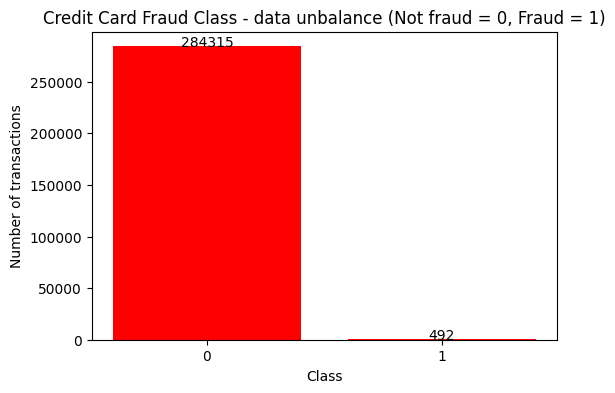

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (replace with your actual data_df)
# data_df = pd.DataFrame({'Class': [0, 1], ...})  # Uncomment and adjust if needed
temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index, 'values': temp.values})

# Create bar plot
plt.figure(figsize=(6, 4))  # Width=6, Height=4 (adjustable)
plt.bar(df['Class'], df['values'], color='red')

# Add labels and title
plt.title('Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)')
plt.xlabel('Class')
plt.ylabel('Number of transactions')

# Add text on top of bars
for i, v in enumerate(df['values']):
    plt.text(i, v + 0.5, str(v), ha='center')

# Display plot
plt.xticks(df['Class'])  # Ensure x-axis shows class labels
plt.show()

Only **492** (or **0.172%**) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable **Class**.

# <a id="5">Data exploration</a>

## Transactions in time

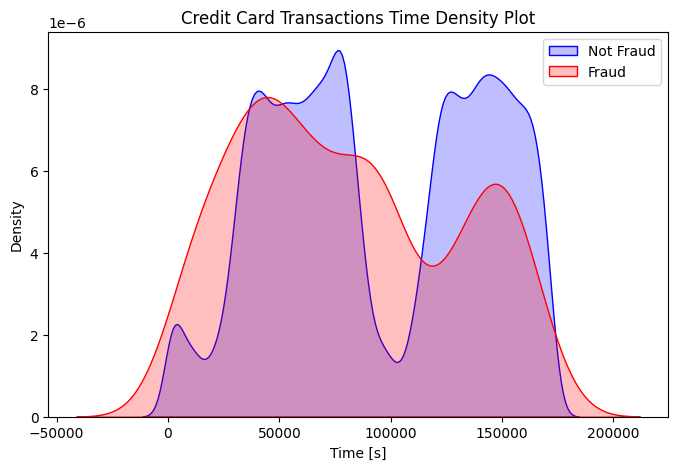

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract Time data for each class
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]

# Create the plot
plt.figure(figsize=(8, 5))  # Adjust size as needed

# Plot KDE (density) for each class
sns.kdeplot(class_0, label='Not Fraud', color='blue', fill=True)
sns.kdeplot(class_1, label='Fraud', color='red', fill=True)

# Add titles and labels
plt.title('Credit Card Transactions Time Density Plot')
plt.xlabel('Time [s]')
plt.ylabel('Density')

# Add legend
plt.legend()

# Display the plot
plt.show()

Fraudulent transactions were more evenly distributed across all hours, including low-activity periods such as nighttime in the European timezone, suggesting a temporal distinction between the two types of transactions.


## Transactions amount

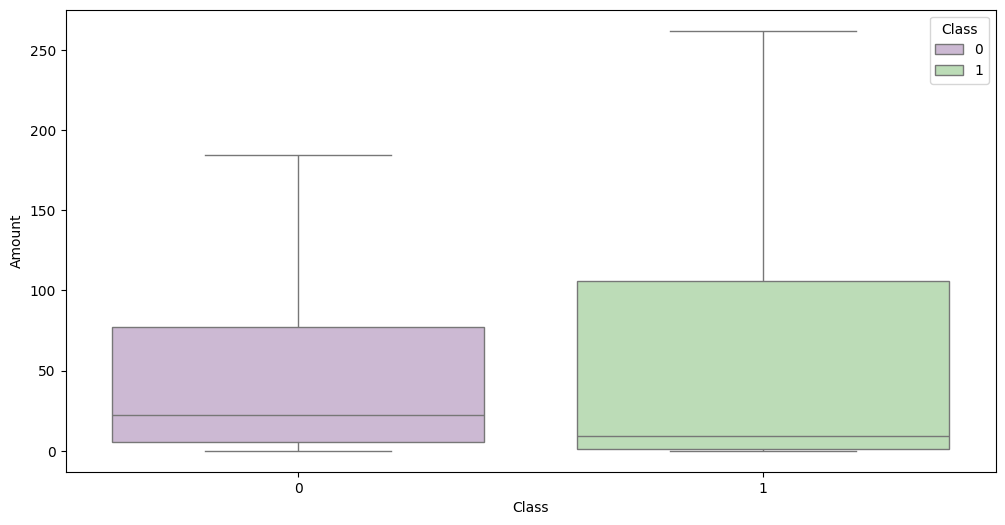

In [ ]:
#Convert the data into hours
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

#Finding statistical properties of each dataset
tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']

fig, (ax1) = plt.subplots(ncols=1, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

The real transaction have a larger mean value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers.

## Fradulant transaction over Amount and Time

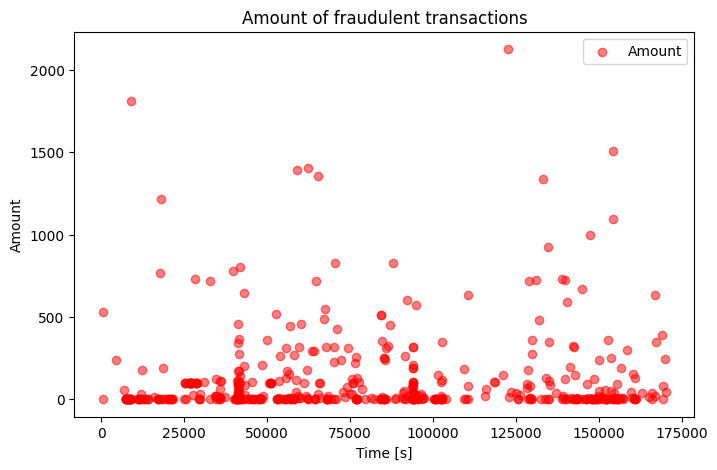

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter fraudulent transactions
fraud = data_df.loc[data_df['Class'] == 1]

# Create the scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(
    fraud['Time'],
    fraud['Amount'],
    color='red',
    edgecolors='red',
    linewidth=1,
    alpha=0.5,
    label='Amount'
)

# Add titles and labels
plt.title('Amount of fraudulent transactions')
plt.xlabel('Time [s]')
plt.ylabel('Amount')

# Add legend (optional, since there's only one dataset)
plt.legend()

# Display the plot
plt.show()

## Features correlation

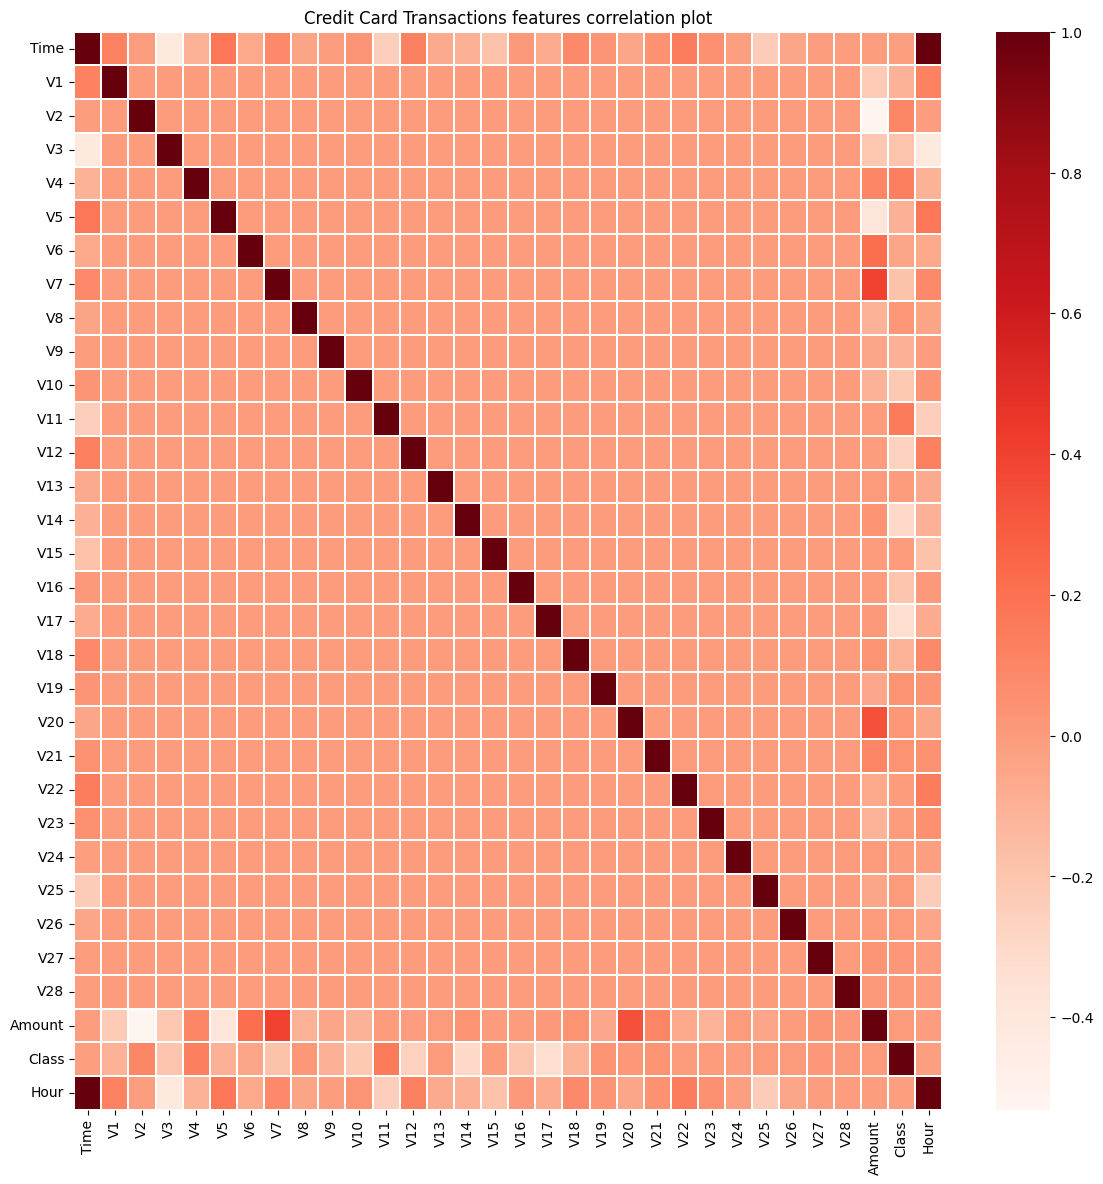

In [ ]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

As expected, the PCA features (V1–V28) showed minimal interdependence among themselves. However, certain features demonstrated correlations with the Time and Amount variables—for instance, V3 showed an inverse correlation with Time, while V7 and V20 were positively correlated with Amount, and V1 and V5 were inversely correlated with it.

### The direct correlated values: V20<->Amount and V7<->Amount.

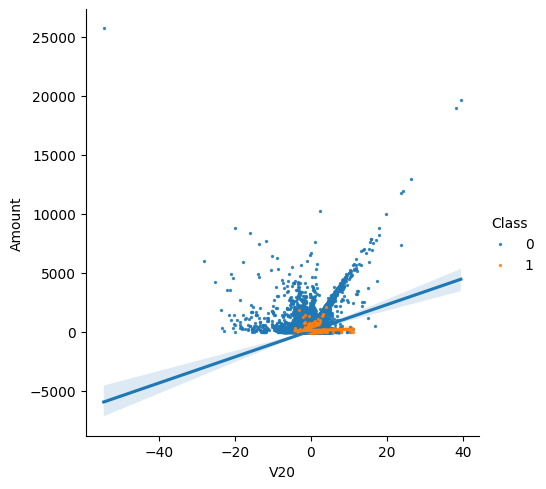

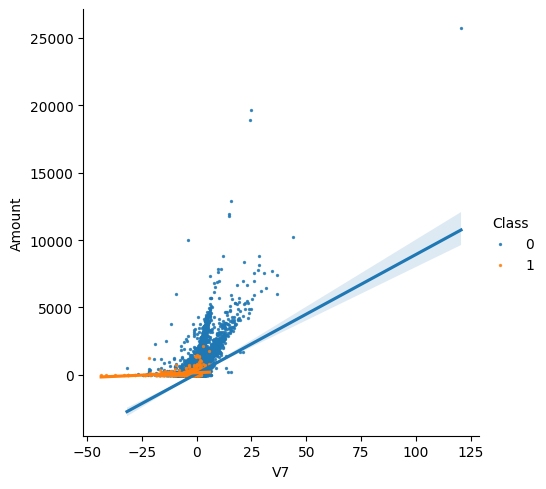

In [ ]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are correlated (the regression lines for **Class = 0** have a positive slope, whilst the regression line for **Class = 1** have a smaller positive slope).


### The Inverse correlated values: V2<->Amount and V5<->Amount.

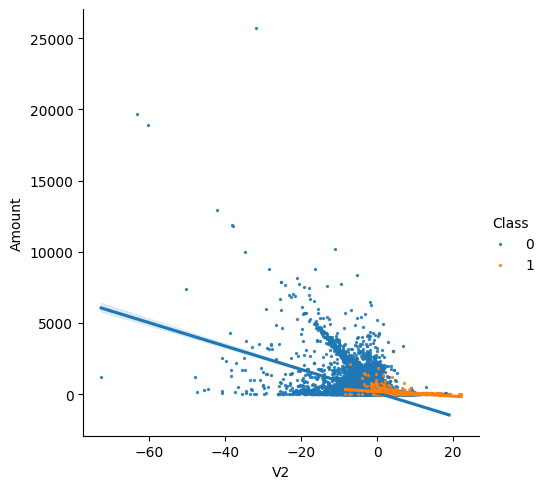

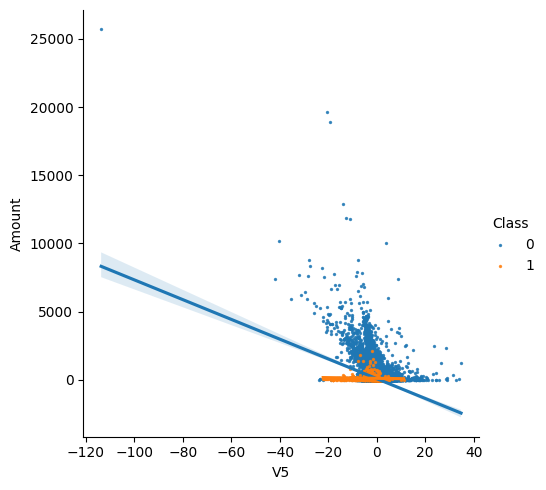

In [ ]:
s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are inverse correlated (the regression lines for **Class = 0** have a negative slope while the regression lines for **Class = 1** have a very small negative slope).


## Features density plot

<ipython-input-16-49894014f345>:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


<ipython-input-16-49894014f345>:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


<ipython-input-16-49894014f345>:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


<ipython-input-16-49894014f345>:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameter

<Figure size 640x480 with 0 Axes>

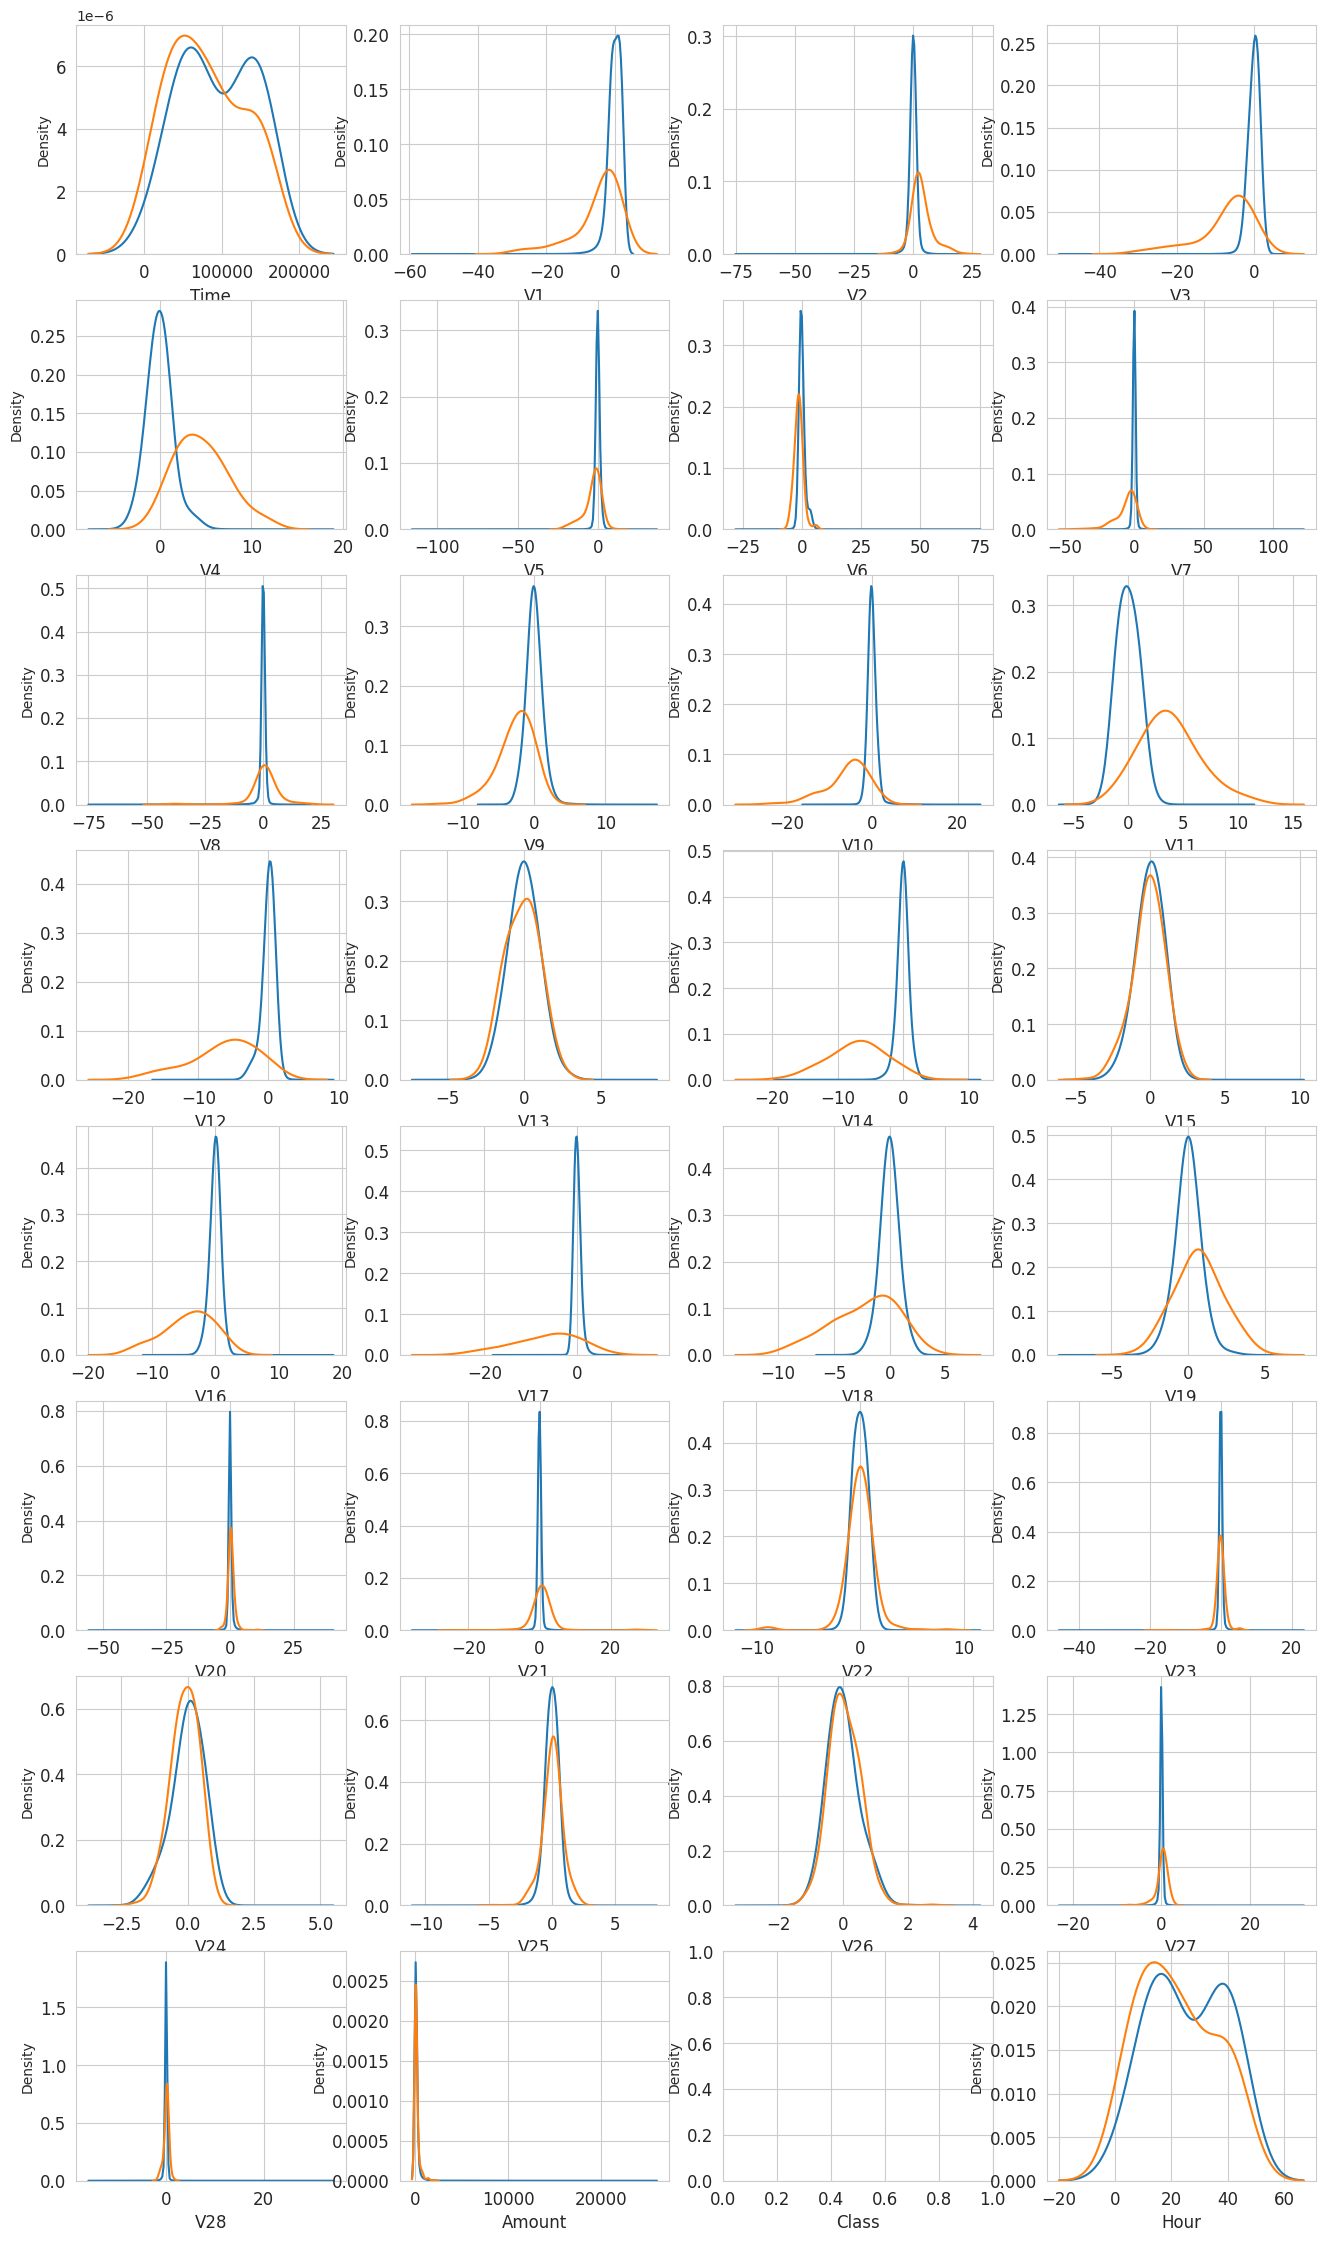

In [ ]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

For some of the features we can observe a good selectivity in terms of distribution for the two values of **Class**: **V4**, **V11** have clearly separated distributions for **Class** values 0 and 1, **V12**, **V14**, **V18** are partially separated, **V1**, **V2**, **V3**, **V10** have a quite distinct profile, whilst **V25**, **V26**, **V28** have similar profiles for the two values of **Class**.  

In general, with just few exceptions (**Time** and **Amount**), the features distribution for legitimate transactions (values of **Class = 0**)  is centered around 0, sometime with a long queue at one of the extremities. In the same time, the fraudulent transactions (values of **Class = 1**) have a skewed (asymmetric) distribution.

# <a id="6">Predictive models</a>  



### Define predictors and target values

In [ ]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

### Split data in train, test and validation set

In [ ]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

## <a>RandomForestClassifier</a>



Let's run a model using the training set for training. Then, we will use the validation set for validation.

Validation criterion -> **GINI**.

Number of estimators -> **100**

Number of parallel jobs -> **4**.

In [ ]:
clf = RandomForestClassifier(n_jobs=NO_JOBS,
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

Let's train the **RandonForestClassifier** using the **train_df** data and **fit** function.

In [ ]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

Let's now predict the **target** values for the **valid_df** data, using **predict** function.

In [ ]:
preds = clf.predict(valid_df[predictors])


### Features importance

<ipython-input-22-45dfd5fcf92d>:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



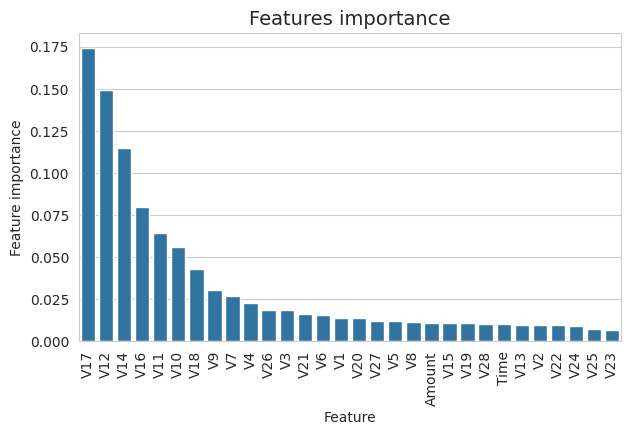

In [ ]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()


The most important features are **V17**, **V12**, **V14**, **V10**, **V11**, **V16**.


### Confusion matrix

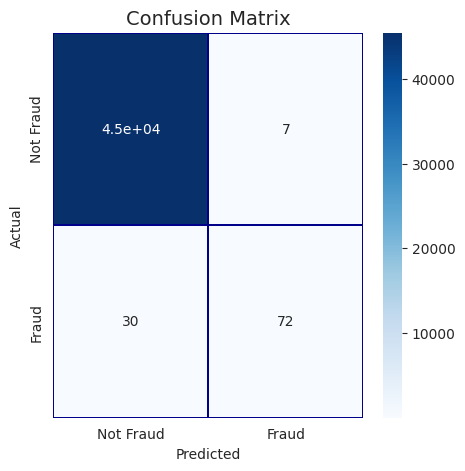

In [ ]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

## ROC Curve

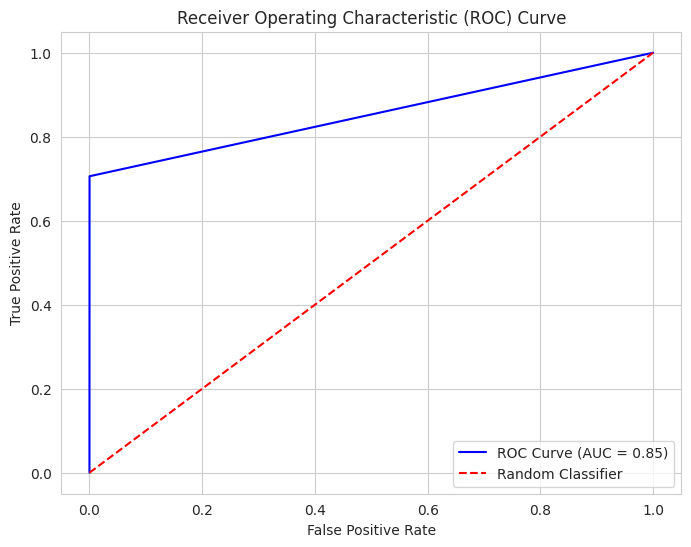

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming preds are predicted probabilities for the positive class
# If preds are not probabilities, use clf.predict_proba(valid_df[predictors])[:, 1] instead
fpr, tpr, _ = roc_curve(valid_df[target].values, preds)

# Calculate AUC
auc_score = roc_auc_score(valid_df[target].values, preds)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()

Calculate AUC of ROC Curve

In [ ]:
roc_auc_score(valid_df[target].values, preds)

np.float64(0.8528641975628091)

The **ROC-AUC** score obtained with **RandomForrestClassifier** is **0.85**.





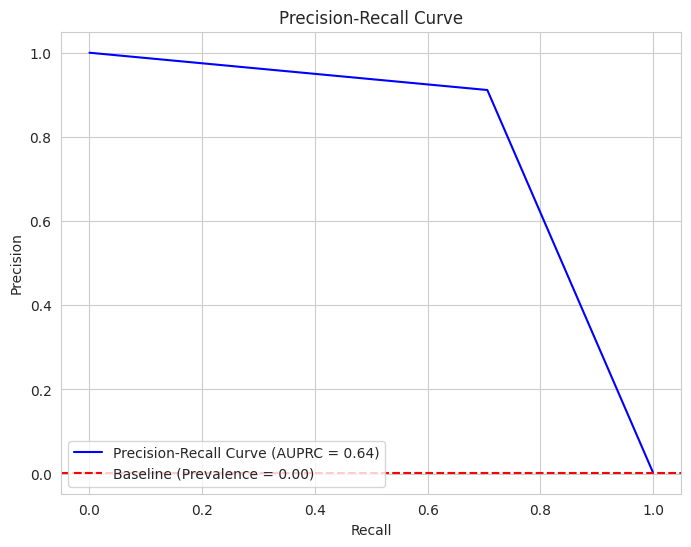

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# True labels and predicted probabilities from RandomForestClassifier
y_true = valid_df[target].values
y_scores = preds

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)

# Compute AUPRC (Area Under the Precision-Recall Curve)
auprc = average_precision_score(y_true, y_scores)

# Compute baseline AUPRC (prevalence of positive class)
baseline = np.mean(y_true)  # Proportion of positive labels

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall Curve (AUPRC = {auprc:.2f})')
plt.axhline(y=baseline, color='red', linestyle='--', label=f'Baseline (Prevalence = {baseline:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)

# Display the plot
plt.show()

The **AUPRC** score obtained with **RandomForrestClassifier** is **0.64**.





## <a id="64">LightGBM</a>

### Define model parameters

In [ ]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced
         }

In [ ]:
dtrain = lgb.Dataset(train_df[predictors].values,
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

### Run the model

In [ ]:
import lightgbm as lgb

# Assuming params, dtrain, dvalid, MAX_ROUNDS, EARLY_STOP, VERBOSE_EVAL are defined
# Initialize a dictionary to store evaluation results (optional, if needed)
evals_results = {}

# Train the model
model = lgb.train(
    params,
    dtrain,
    num_boost_round=MAX_ROUNDS,
    valid_sets=[dtrain, dvalid],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=2*EARLY_STOP),
        lgb.log_evaluation(period=VERBOSE_EVAL),
        lgb.record_evaluation(evals_results)  # Use callback to store results
    ],
    feval=None
)

# Print evaluation results (optional)
print("Evaluation results:", evals_results)

Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.997909	valid's auc: 0.952288
[100]	train's auc: 0.999032	valid's auc: 0.945553
Early stopping, best iteration is:
[29]	train's auc: 0.996594	valid's auc: 0.957864
Evaluation results: {'train': OrderedDict([('auc', [np.float64(0.9692017517831042), np.float64(0.9717460456412524), np.float64(0.9848252252825814), np.float64(0.9873655211067771), np.float64(0.9892422096129411), np.float64(0.9927239950629018), np.float64(0.9929337686832295), np.float64(0.9931842900382257), np.float64(0.9935978781240088), np.float64(0.9938559692162754), np.float64(0.994339627110384), np.float64(0.9944651388492559), np.float64(0.9947844699687016), np.float64(0.9949329088217093), np.float64(0.9952204262017882), np.float64(0.9953196286034887), np.float64(0.9954386506426982), np.float64(0.9955251294434547), np.float64(0.9956289646380528), np.float64(0.9957240458436174), np.float64(0.995809008802117), np.float64(0.9958843082662289), n

Best validation score  was obtained for round **85**, for which **AUC ~= 0.974**.

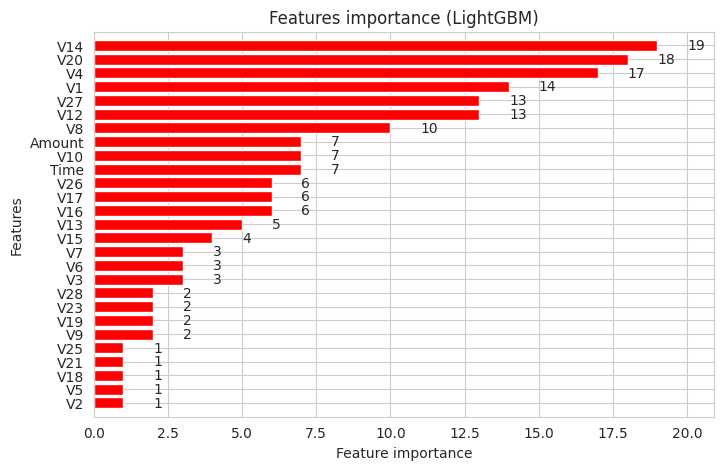

In [ ]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red")
plt.show()

Let's predict now the target for the test data.

### Predict test data

In [ ]:
preds = model.predict(test_df[predictors])

### Confusion Matrix

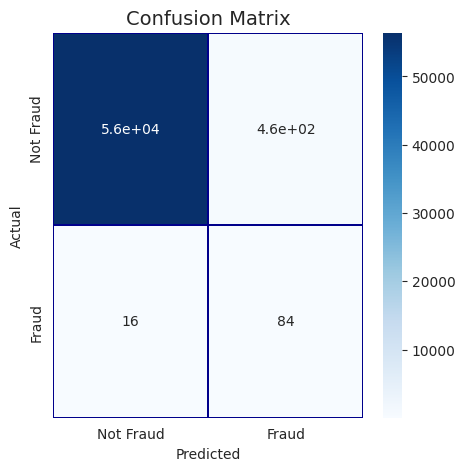

In [ ]:
y_pred_binary = (preds >= 0.5).astype(int)
y_true = test_df[target].values

# Compute confusion matrix using pd.crosstab
cm = pd.crosstab(y_true, y_pred_binary, rownames=['Actual'], colnames=['Predicted'])

# Plot confusion matrix as a heatmap
fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True, ax=ax1,
            linewidths=.2, linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)

# Display the plot
plt.show()

### Area under curve

Let's calculate the ROC-AUC score for the prediction.

In [ ]:
roc_auc_score(test_df[target].values, preds)

np.float64(0.9473337202349548)

#### ROC Curve

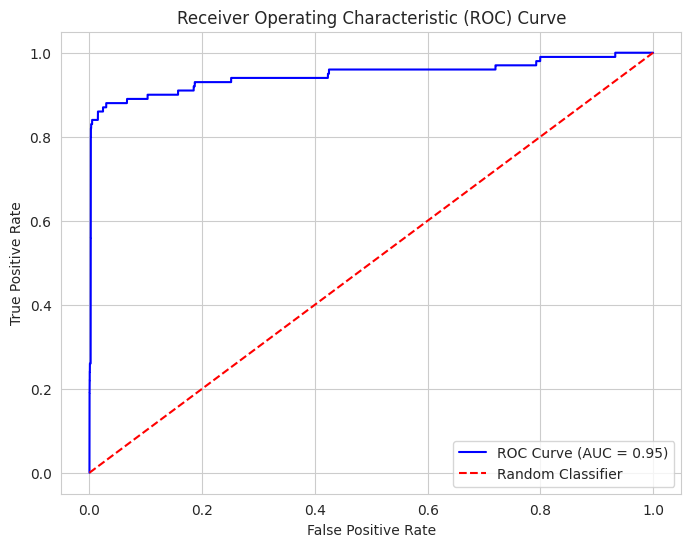

In [ ]:
fpr, tpr, _ = roc_curve(test_df[target].values, preds)

# Calculate AUC
auc_score = roc_auc_score(test_df[target].values, preds)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Display the plot
plt.show()

The ROC-AUC score obtained for the test set is **0.946**.

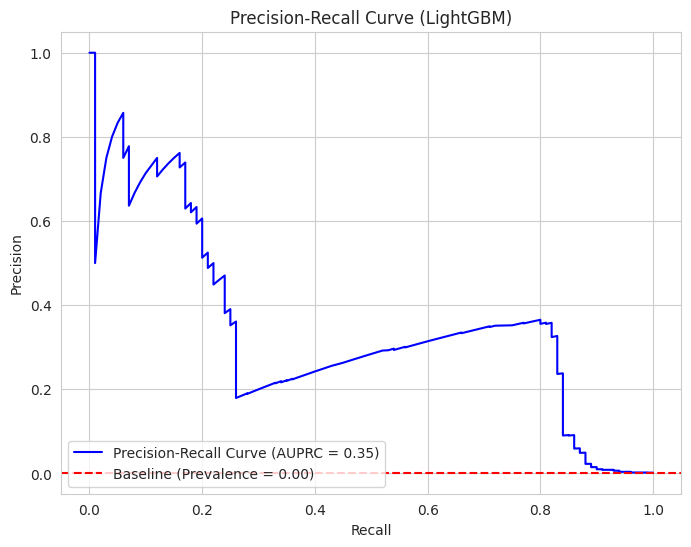

In [ ]:
# Predict on validation set
y_scores = model.predict(test_df[predictors])

# Use the corresponding true labels
y_true = test_df[target].values


# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)

# Compute AUPRC
auprc = average_precision_score(y_true, y_scores)

# Compute baseline AUPRC (prevalence of positive class)
baseline = np.mean(y_true)  # Proportion of positive labels

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall Curve (AUPRC = {auprc:.2f})')
plt.axhline(y=baseline, color='red', linestyle='--', label=f'Baseline (Prevalence = {baseline:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (LightGBM)')
plt.legend(loc='lower left')
plt.grid(True)

# Display the plot
plt.show()

The **AUPRC** score obtained with **RandomForrestClassifier** is **0.35**.





### Training and validation using cross-validation

Test set is calculated as an average of the predictions

In [ ]:
# Assuming train_df, test_df, predictors, target, NUMBER_KFOLDS, RANDOM_STATE, VERBOSE_EVAL, EARLY_STOP are defined
kf = KFold(n_splits=NUMBER_KFOLDS, random_state=RANDOM_STATE, shuffle=True)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0

for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx], train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx], train_df[target].iloc[valid_idx]

    model = lgb.LGBMClassifier(
        nthread=-1,
        n_estimators=2000,
        learning_rate=0.01,
        num_leaves=80,
        colsample_bytree=0.98,
        subsample=0.78,
        reg_alpha=0.04,
        reg_lambda=0.073,
        subsample_for_bin=50,
        boosting_type='gbdt',
        is_unbalance=False,
        min_split_gain=0.025,
        min_child_weight=40,
        min_child_samples=510,
        objective='binary',
        metric='auc',
        verbosity=-1,
        feval=None
    )

    model.fit(
        train_x,
        train_y,
        eval_set=[(train_x, train_y), (valid_x, valid_y)],
        eval_metric='auc',
        eval_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOP),
            lgb.log_evaluation(period=VERBOSE_EVAL)
        ]
    )

    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = n_fold + 1

    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold = n_fold + 1

train_auc_score = roc_auc_score(train_df[target], oof_preds)
print('Full AUC score %.6f' % train_auc_score)

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.972313	valid's auc: 0.990201
[100]	train's auc: 0.97139	valid's auc: 0.992925
[150]	train's auc: 0.974237	valid's auc: 0.997586
[200]	train's auc: 0.974713	valid's auc: 0.997987
[250]	train's auc: 0.975847	valid's auc: 0.998143
Early stopping, best iteration is:
[231]	train's auc: 0.975418	valid's auc: 0.998184
Fold  1 AUC : 0.998184
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.979082	valid's auc: 0.963933
Early stopping, best iteration is:
[44]	train's auc: 0.979318	valid's auc: 0.966302
Fold  2 AUC : 0.966302
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.980517	valid's auc: 0.937209
[100]	train's auc: 0.981387	valid's auc: 0.938327
[150]	train's auc: 0.981624	valid's auc: 0.939771
[200]	train's auc: 0.981827	valid's auc: 0.942898
[250]	train's auc: 0.983151	valid's auc: 0.942886
Early stopping, best iteration is:
[202]	train's auc: 0.

#### Confusion Matrix

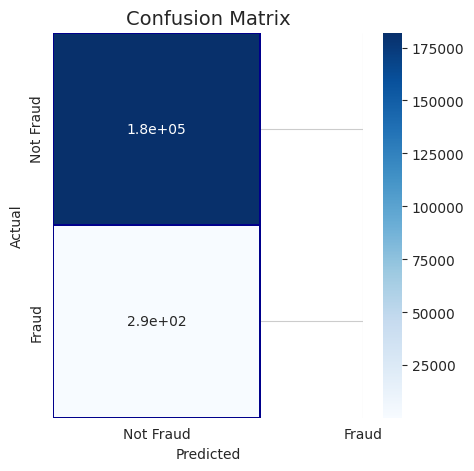

In [ ]:
# Convert probabilities to binary predictions using 0.5 threshold
y_pred_binary = (oof_preds >= 0.5).astype(int)
y_true = train_df[target].values

# Compute confusion matrix using pd.crosstab
cm = pd.crosstab(y_true, y_pred_binary, rownames=['Actual'], colnames=['Predicted'])

# Plot confusion matrix as a heatmap
fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True, ax=ax1,
            linewidths=.2, linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)

# Display the plot
plt.show()

## ROC Curve

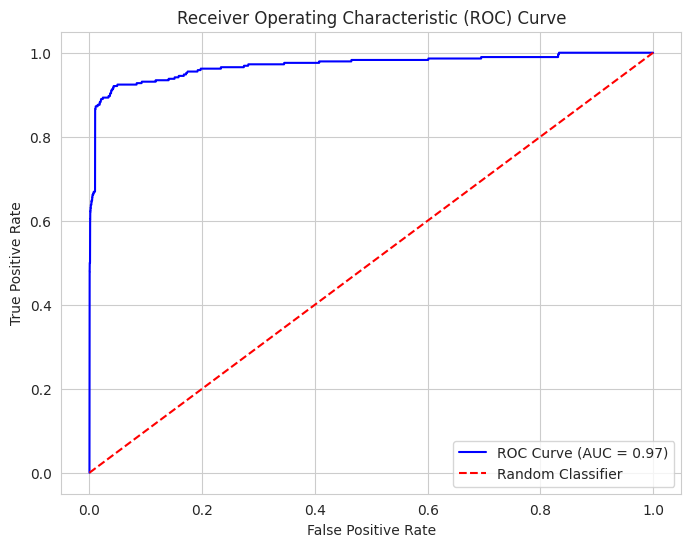

In [ ]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(train_df[target].values, oof_preds)

# Calculate AUC
auc_score = roc_auc_score(train_df[target].values, oof_preds)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Display the plot
plt.show()

The AUC score for the prediction from the test data was 0.97.

We prepare the test prediction, from the averaged predictions for test over the 5 folds.

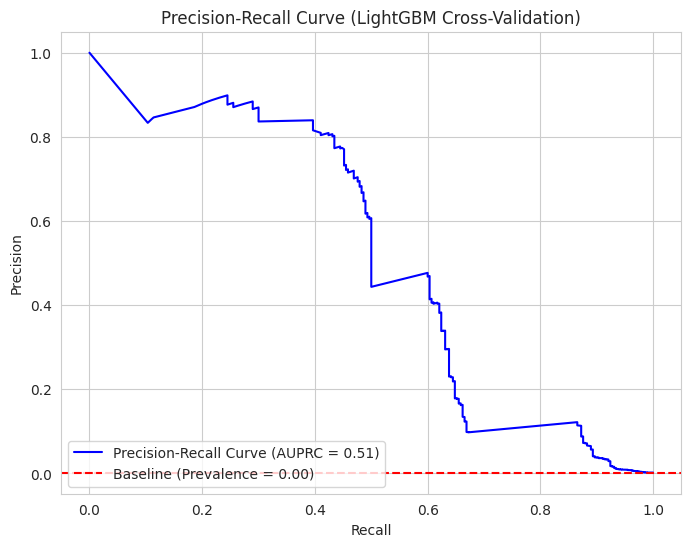

In [ ]:
y_true = train_df[target].values
y_scores = oof_preds

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)

# Compute AUPRC
auprc = average_precision_score(y_true, y_scores)

# Compute baseline AUPRC (prevalence of positive class)
baseline = np.mean(y_true)  # Proportion of positive labels

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall Curve (AUPRC = {auprc:.2f})')
plt.axhline(y=baseline, color='red', linestyle='--', label=f'Baseline (Prevalence = {baseline:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (LightGBM Cross-Validation)')
plt.legend(loc='lower left')
plt.grid(True)

# Display the plot
plt.show()

The **AUPRC** score obtained with **LightBGMtClassifier** with KFold cross-validation is **0.51**.





## <a id="63">XGBoost</a>

### Prepare the model

We initialize the DMatrix objects for training and validation,

In [ ]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

### Train the model

Let's train the model.

In [ ]:
model = xgb.train(params,
                dtrain,
                MAX_ROUNDS,
                watchlist,
                early_stopping_rounds=EARLY_STOP,
                maximize=True,
                verbose_eval=VERBOSE_EVAL)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning:

Pass `evals` as keyword args.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[07:57:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.




[0]	train-auc:0.94070	valid-auc:0.88630
[50]	train-auc:0.94043	valid-auc:0.89529
[100]	train-auc:0.97414	valid-auc:0.96283
[150]	train-auc:0.98510	valid-auc:0.98126
[200]	train-auc:0.99295	valid-auc:0.98520
[250]	train-auc:0.99519	valid-auc:0.98406
[262]	train-auc:0.99567	valid-auc:0.98377


The best validation score (ROC-AUC) was **0.974**, for round **241**.

### Plot variable importance

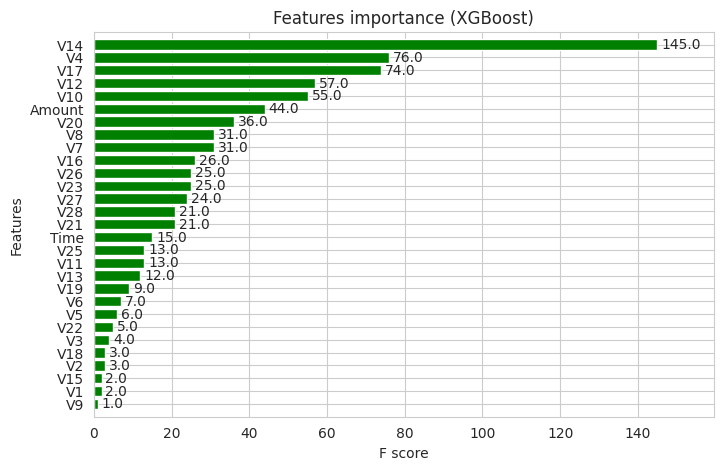

In [ ]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green")
plt.show()

### Predict test set


We used the train and validation sets for training and validation. We will use the trained model now to predict the target value for the test set.

In [ ]:
preds = model.predict(dtest)

### Area under curve

### ROC Curve

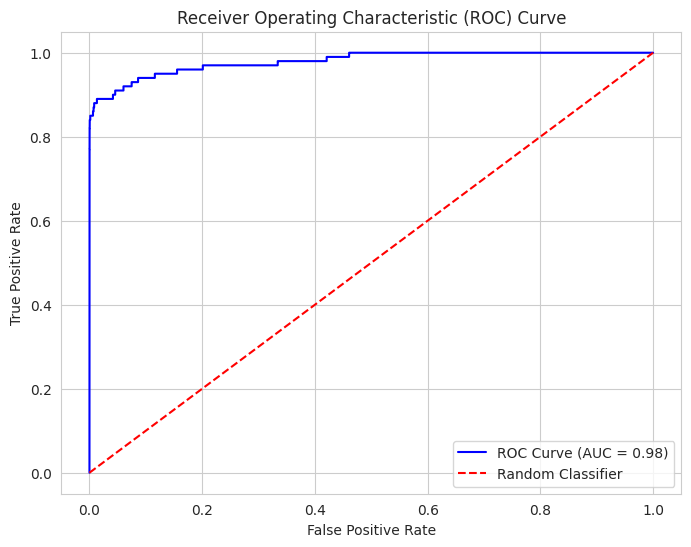

In [ ]:
fpr, tpr, _ = roc_curve(test_df[target].values, preds)

# Calculate AUC
auc_score = roc_auc_score(test_df[target].values, preds)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
roc_auc_score(test_df[target].values, preds)

np.float64(0.9796317400021104)

The **ROC-AUC** score obtained with **xGBoostClassifier** is **0.98**.





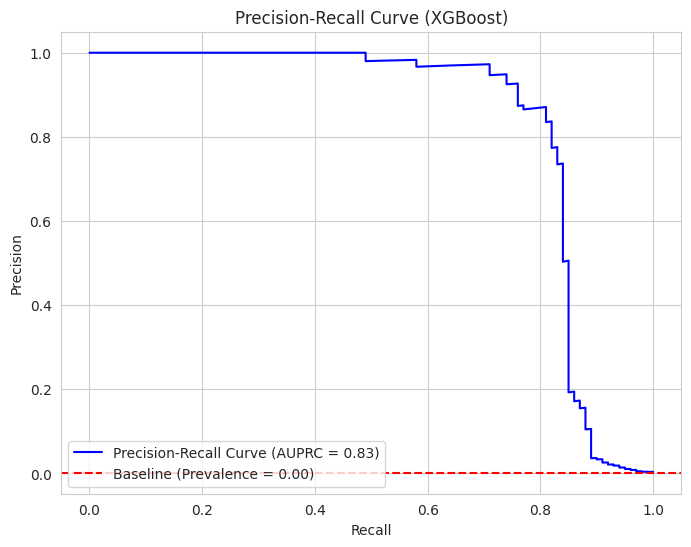

In [ ]:
# True labels and predicted probabilities from XGBoost
y_true = test_df[target].values
y_scores = preds

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)

# Compute AUPRC
auprc = average_precision_score(y_true, y_scores)

# Compute baseline AUPRC (prevalence of positive class)
baseline = np.mean(y_true)  # Proportion of positive labels

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall Curve (AUPRC = {auprc:.2f})')
plt.axhline(y=baseline, color='red', linestyle='--', label=f'Baseline (Prevalence = {baseline:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (XGBoost)')
plt.legend(loc='lower left')
plt.grid(True)

# Display the plot
plt.show()

The AUPRC score for the prediction of fresh data (test set) is **0.84**.

#### Confusion Matrix

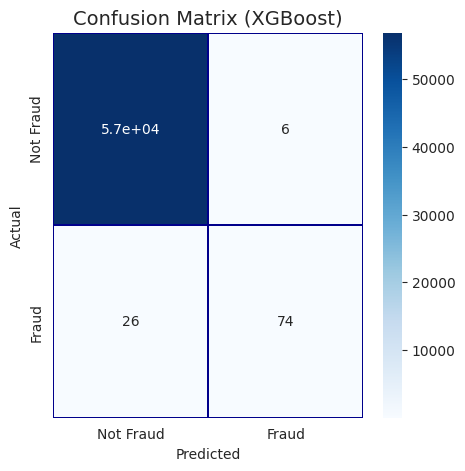

In [ ]:
y_pred_binary = (preds >= 0.5).astype(int)
y_true = test_df[target].values

# Compute confusion matrix using pd.crosstab
cm = pd.crosstab(y_true, y_pred_binary, rownames=['Actual'], colnames=['Predicted'])

# Plot confusion matrix as a heatmap
fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True, ax=ax1,
            linewidths=.2, linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix (XGBoost)', fontsize=14)

# Display the plot
plt.show()

### KFold Cross Validation and SMOTE to improve AUPRC

---




=== Fold 1 ===
AUPRC: 0.7372

=== Fold 2 ===
AUPRC: 0.8782

=== Fold 3 ===
AUPRC: 0.8420

=== Fold 4 ===
AUPRC: 0.7731

=== Fold 5 ===
AUPRC: 0.8771


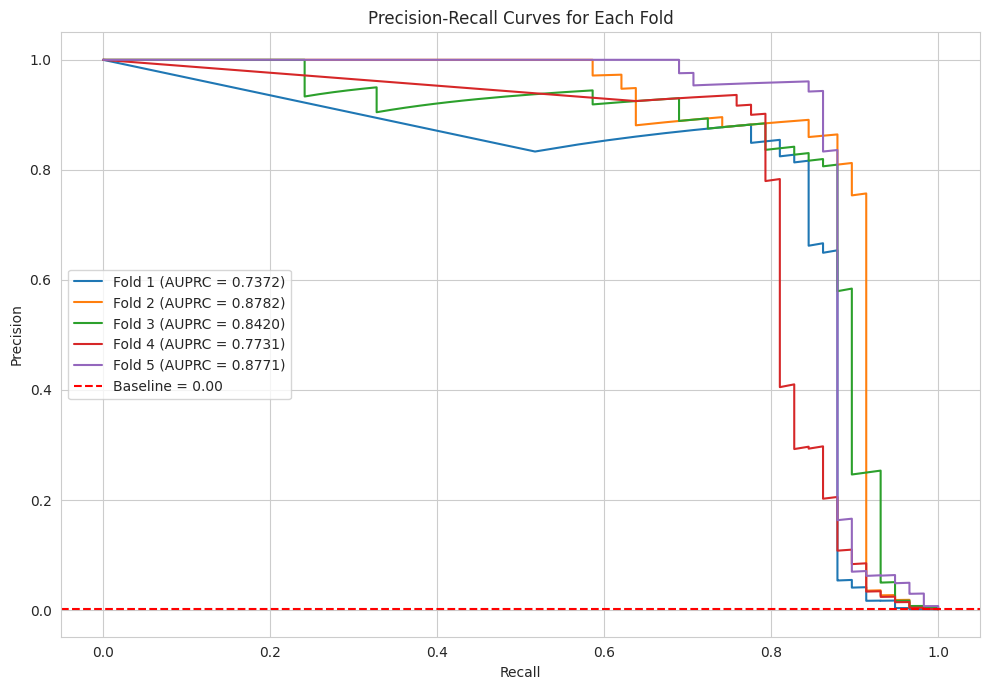


Average AUPRC across folds: 0.8215 ± 0.0569


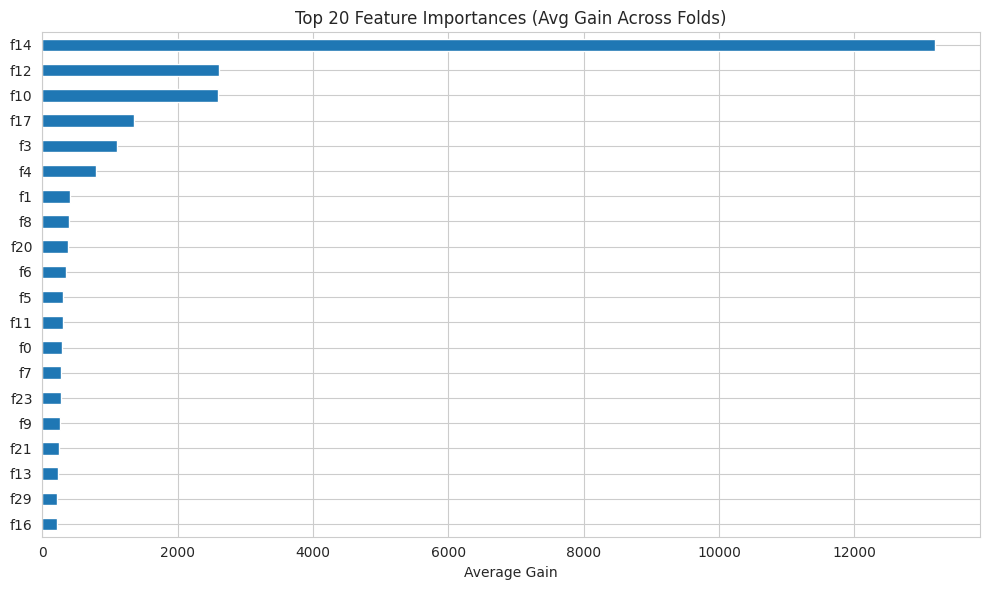

In [ ]:


X = train_df[predictors]
y = train_df[target]

# === KFold setup ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auprc_scores = []
feature_importance_total = None

# === Plot PR Curves per fold ===
plt.figure(figsize=(10, 7))

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    print(f"\n=== Fold {fold+1} ===")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # === SMOTE ===
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train)

    # === Standardize ===
    scaler = StandardScaler()
    X_res_scaled = scaler.fit_transform(X_res)
    X_valid_scaled = scaler.transform(X_valid)

    # === DMatrix ===
    dtrain = xgb.DMatrix(X_res_scaled, label=y_res)
    dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid)

    # === Parameters ===
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'eta': 0.05,
        'max_depth': 4,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42
    }

    # === Train Model ===
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=MAX_ROUNDS,
        evals=watchlist,
        early_stopping_rounds=EARLY_STOP,
        maximize=True,
        verbose_eval=False
    )

    # === Evaluate ===
    y_probs = model.predict(dvalid)
    auprc = average_precision_score(y_valid, y_probs)
    auprc_scores.append(auprc)
    print(f"AUPRC: {auprc:.4f}")

    # === PR Curve ===
    precision, recall, _ = precision_recall_curve(y_valid, y_probs)
    plt.plot(recall, precision, label=f'Fold {fold+1} (AUPRC = {auprc:.4f})')

    # === Feature Importance Accumulation ===
    fold_importance = model.get_score(importance_type='gain')
    fi_df = pd.DataFrame.from_dict(fold_importance, orient='index', columns=[f'fold_{fold+1}'])

    if feature_importance_total is None:
        feature_importance_total = fi_df
    else:
        feature_importance_total = feature_importance_total.join(fi_df, how='outer')

# === PR Curve Final Plot ===
baseline = np.mean(y)
plt.axhline(y=baseline, linestyle='--', color='red', label=f'Baseline = {baseline:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Each Fold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === AUPRC Summary ===
print(f"\nAverage AUPRC across folds: {np.mean(auprc_scores):.4f} ± {np.std(auprc_scores):.4f}")

# === Feature Importance Summary ===
feature_importance_total.fillna(0, inplace=True)
feature_importance_total['avg_gain'] = feature_importance_total.mean(axis=1)
top_features = feature_importance_total.sort_values(by='avg_gain', ascending=False).head(20)

# === Plot Feature Importances ===
plt.figure(figsize=(10, 6))
top_features['avg_gain'].plot(kind='barh')
plt.title("Top 20 Feature Importances (Avg Gain Across Folds)")
plt.xlabel("Average Gain")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# <a id="7">Conclusions</a>

Gradient boosting models—XGBoost and LightGBM—were evaluated alongside the RandomForestClassifier to address the dataset’s severe class imbalance (fraud rate of 0.172%). PCA-transformed features (V1–V28) and techniques like scale_pos_weight played a central role in enabling models to identify minority class instances.
XGBoost outperformed all models, achieving a ROC-AUC of 0.984 and an AUPRC of 0.83. Its strong performance was driven by focused feature importance (notably V4, V12, V10), shallow trees (max_depth=2), and early stopping, making it the most viable candidate for deployment. In contrast, LightGBM underperformed in terms of AUPRC (0.51) despite a decent ROC-AUC (0.9578), even falling short of the RandomForestClassifier (AUPRC 0.65). This indicates that while LightGBM was able to separate classes reasonably well on a global scale, it struggled to capture the rare fraud cases effectively, likely due to sensitivity in hyperparameter defaults and cross-validation variance.
The RandomForestClassifier, although simpler, showed competitive performance with AUPRC of 0.65 and ROC-AUC of 0.85, serving as a solid baseline. However, it had higher false positives and lower recall, revealing limitations in handling rare-event detection.
The PCA transformation, while effective in obfuscating original features, limits interpretability. Features such as Time and Amount showed minimal importance, validating the anonymization’s success. SMOTE’s application with XGBoost led to a dip in AUPRC, suggesting that oversampling must be applied cautiously in extremely imbalanced contexts.


Key limitations:


Incomplete hyperparameter tuning for models like LightGBM.Dataset spans only two days, lacking seasonal or evolving fraud patterns.


Future directions:

Conduct extensive hyperparameter optimization (e.g., XGBoost’s eta, LightGBM’s num_leaves).
Evaluate advanced sampling methods such as ADASYN.
Test models on longitudinal data (multi-month scope) to capture evolving fraud patterns.


Overall, XGBoost is best suited for deployment, with RandomForestClassifier as a reasonable fallback. LightGBM requires further tuning to meet deployment standards in high-stakes fraud detection tasks.


In [ ]:
!jupyter nbconvert --to html /content/Credit_Card_fraud.ipynb


[NbConvertApp] WARNING | pattern '/content/Credit_Card_fraud.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True

In [ ]:
from google.colab import files
files.download('/content/Credit_Card_fraud.html')

FileNotFoundError: Cannot find file: /content/Credit_Card_fraud.html